In [1]:
# default_exp feature_importance

In [2]:
import sklearn

In [3]:
# export

import pandas as pd
import numpy as np
import logging

from mlbt.utils import PurgedKFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

def feat_importance(
    events,
    X,
    y,
    n_estimators=200,#1000
    cv=10,
    max_samples=1.0,
    pct_embargo=0,
    scoring="accuracy",
    method="MDI",
    min_w_leaf=0.0,
    n_jobs=None,
    **kwargs
):
    logging.info(f"feat_importance for {len(X.columns)} features")
    # 1) prepare classifier, cv. max_features=1 to prevent masking
    # feature importance from a random forest
    clf = DecisionTreeClassifier(
        criterion="entropy",
        max_features=1,
        class_weight="balanced",
        min_weight_fraction_leaf=min_w_leaf,
    )

    clf = BaggingClassifier(
        base_estimator=clf,
        n_estimators=n_estimators,
        max_features=1.0,
        max_samples=max_samples,
        oob_score=True,
        n_jobs=n_jobs,
    )

    if method == "MDI":
        fit = clf.fit(X=X, y=y)
        imp = feat_imp_MDI(fit, feat_names=X.columns)
    elif method == "MDA":
        sample_weight = pd.Series(1, index=events.index)
        imp = feat_imp_MDA(
            clf=clf,
            X=X,
            y=y,
            cv=cv,
            t1=events["t1"],
            pct_embargo=pct_embargo,
            scoring=scoring,
        )

    imp = imp.sort_values("mean", ascending=True)

    return imp


def feat_imp_MDI(fit, feat_names):
    # feat importance based on IS mean impurity reduction
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient="index")
    df0.columns = feat_names
    df0 = df0.replace(0, np.nan)  # because max_features = 1
    imp = pd.concat(
        {"mean": df0.mean(), "std": df0.std() * df0.shape[0] ** -0.5}, axis=1
    )
    imp /= imp["mean"].sum()
    return imp


def feat_imp_MDA(clf, X, y, cv, t1, pct_embargo, scoring="neg_log_loss"):
    # feat importance based on OOS score reduction
    if scoring not in ["neg_log_loss", "accuracy"]:
        raise ValueError("wrong scoring method")
    from sklearn.metrics import log_loss, accuracy_score
    logging.debug(f"MDA with {cv}-fold CV")

    cv_gen = PurgedKFold(n_splits=cv, t1=t1, pct_embargo=pct_embargo)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        logging.debug(f"MDA with {cv}-fold CV: fold {i+1}/{cv}")
        X0, y0 = X.iloc[train, :], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        fit = clf.fit(X=X0, y=y0)
        if scoring == "neg_log_loss":
            prob = fit.predict_proba(X1)
            scr0.loc[i] = -log_loss(
                y1, prob, labels=clf.classes_
            )
        else:
            pred = fit.predict(X1)
            scr0.loc[i] = accuracy_score(y1, pred)

        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values)  # permutation of a single column
            if scoring == "neg_log_loss":
                prob = fit.predict_proba(X1_)
                scr1.loc[i, j] = -log_loss(
                    y1, prob, labels=clf.classes_
                )
            else:
                pred = fit.predict(X1_)
                scr1.loc[i, j] = accuracy_score(y1, pred)

    imp = (-scr1).add(scr0, axis=0)
    if scoring == "neg_log_loss":
        imp = imp / -scr1
    else:
        imp = imp / (1.0 - scr1)

    imp = pd.concat(
        {"mean": imp.mean(), "std": imp.std() * imp.shape[0] ** -0.5}, axis=1
    )
    return imp

In [4]:
import pandas as pd

In [5]:

from mlbt.load_data import DATA_DIR

c:\users\doda\anaconda3\envs\fincl\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\doda\anaconda3\envs\fincl\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
x = DATA_DIR / 'dollar' / '@TU#C_fimp_fixed_horizon_50_none_[]_0.5-10-25-250-50-500-60-Num Ticks-VIX.XO-amihud-auto-close-column-com-d-ffd-kyle-lag_change-log_ret-roll-rollimp-size-symbol-time_bars-volratio_MDA.h5'
x = DATA_DIR / 'dollar' / '@TU#C_fimp_fixed_horizon_50_none_[]_amihud-auto-close-ffd-kyle-log-roll-rollimp-stdev-volratio_MDA.h5'



In [7]:
fimp = pd.read_hdf(x, 'table')

In [8]:
import seaborn

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.pyplot as mpl

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 16,66


In [7]:
# seaborn.barplot(y=fimp.index, x=fimp['mean'])

In [19]:
import pandas as pd
from mlbt.load_data import DATA_DIR
files = [x for x in (DATA_DIR / 'dollar').files('*fimp*') if '0.3-' in x]
print(len(files))
imps = [pd.read_hdf(x, 'table') for x in files]


dfs = imps
mean = pd.concat([x["mean"] for x in dfs], axis=1).mean(axis=1)
std = pd.concat([x["std"] for x in dfs], axis=1).std(axis=1) * len(dfs) ** -0.5

res= pd.DataFrame({"mean": mean, "std": std})

47


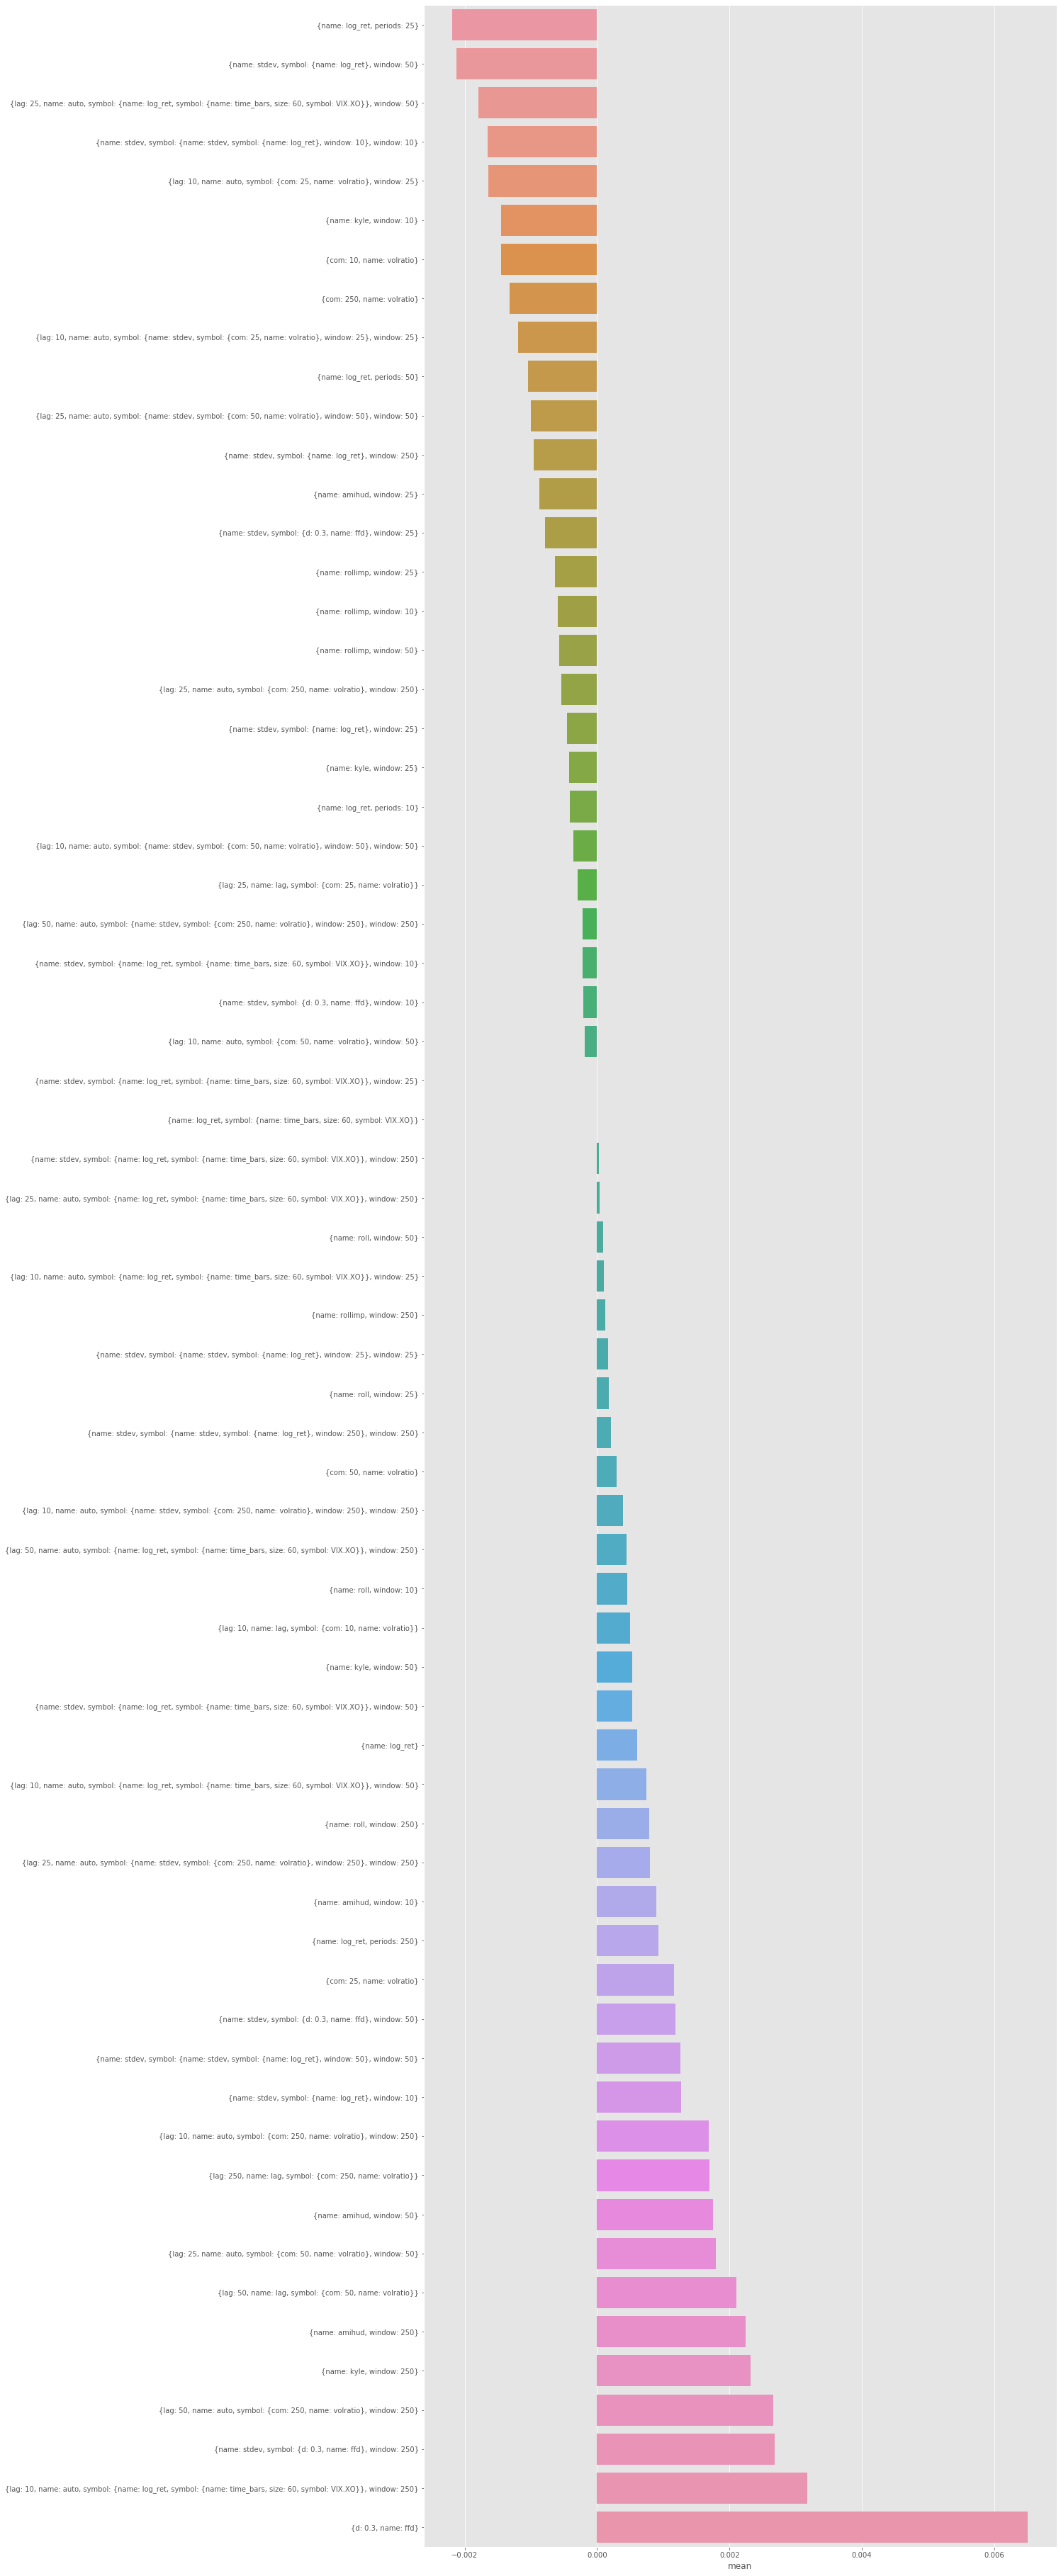

In [20]:
res = res.sort_values('mean')
seaborn.barplot(y=[x.replace('\\','').replace('"', '') for x in res.index.values], x=res['mean'])

['{lag: 5, name: auto, symbol: {name: stdev, symbol: {com: 250, name: volratio}, window: 250}, window: 250}',
 '{name: stdev, symbol: {name: log_ret, symbol: {name: time_bars, size: 60, symbol: VIX.XO}}, window: 250}',
 '{name: stdev, symbol: {name: log_ret, symbol: {name: time_bars, size: 60, symbol: VIX.XO}}, window: 5}',
 '{name: roll, window: 5}',
 '{lag: 5, name: auto, symbol: {com: 250, name: volratio}, window: 250}',
 '{lag: 1, name: auto, symbol: {name: stdev, symbol: {com: 25, name: volratio}, window: 25}, window: 25}',
 '{name: amihud, window: 50}',
 '{lag: 5, name: auto, symbol: {name: log_ret, symbol: {name: time_bars, size: 60, symbol: VIX.XO}}, window: 50}',
 '{name: roll, window: 25}',
 '{lag: 25, name: auto, symbol: {name: log_ret, symbol: {name: time_bars, size: 60, symbol: VIX.XO}}, window: 50}',
 '{lag: 3, name: auto, symbol: {name: stdev, symbol: {com: 250, name: volratio}, window: 250}, window: 250}',
 '{name: stdev, symbol: {name: stdev, symbol: {name: log_ret}, w

In [38]:
[x.basename().split('_')[0] for x in sorted((DATA_DIR / 'dollar').files("*events_100_fixed_horizon_50*"), key=lambda x:x.size)[::-1]]

['@SP#C',
 '@W#C',
 '@BO#C',
 '@QM#C',
 '@QG#C',
 'EZ#C',
 '@KC#C',
 '@C#C',
 'XG#C',
 '@S#C',
 'EX#C',
 '@SB#C',
 '@OJ#C',
 '@NKD#C',
 '@EMD#C',
 'BD#C',
 'LF#C',
 'QNG#C',
 'QCL#C',
 '@HE#C',
 '@CC#C',
 '@CT#C',
 '@LE#C',
 '@ES#C',
 '@TY#C',
 'QSI#C',
 'QPL#C',
 '@FV#C',
 '@O#C',
 'LG#C',
 '@SM#C',
 '@GF#C',
 'QGC#C',
 '@YM#C',
 '@TU#C',
 'QPA#C',
 '@UB#C',
 '@NQ#C',
 '@ED#C',
 'GAS#C',
 '@MME#C',
 'QHG#C',
 'QHO#C',
 '@BP#C',
 '@CD#C',
 '@RP#C',
 '@NE#C',
 '@AD#C']

In [24]:

ranked = [x for x in sorted((DATA_DIR / 'dollar').files("*bars*"), key=lambda x:x.size)[::-1]]

In [27]:
sp = pd.read_hdf(ranked[0], 'table')

In [34]:
sp.groupby(sp.index.year).count()

,Time,Open,High,Low,Close,Volume,Dollar Volume,Num Ticks,Buy Volume
Time,,,,,,,,,
2008,58383,58383,58383,58383,58383,58383,58383,58383,58383
2009,42514,42514,42514,42514,42514,42514,42514,42514,42514
2010,50946,50946,50946,50946,50946,50946,50946,50946,50946
2011,48232,48232,48232,48232,48232,48232,48232,48232,48232
2012,30992,30992,30992,30992,30992,30992,30992,30992,30992
2013,27647,27647,27647,27647,27647,27647,27647,27647,27647
2014,23178,23178,23178,23178,23178,23178,23178,23178,23178
2015,17997,17997,17997,17997,17997,17997,17997,17997,17997
2016,10588,10588,10588,10588,10588,10588,10588,10588,10588


In [62]:
for fn in ranked:
    print(fn)
    x = pd.read_hdf(fn, 'table')
    print(x.groupby(x.index.year).count())

C:\Users\doda/Dropbox/algotrading/data\dollar\@SP#C_bars.h5
       Time   Open   High    Low  Close  Volume  Dollar Volume  Num Ticks  \
Time                                                                        
2008  58383  58383  58383  58383  58383   58383          58383      58383   
2009  42514  42514  42514  42514  42514   42514          42514      42514   
2010  50946  50946  50946  50946  50946   50946          50946      50946   
2011  48232  48232  48232  48232  48232   48232          48232      48232   
2012  30992  30992  30992  30992  30992   30992          30992      30992   
2013  27647  27647  27647  27647  27647   27647          27647      27647   
2014  23178  23178  23178  23178  23178   23178          23178      23178   
2015  17997  17997  17997  17997  17997   17997          17997      17997   
2016  10588  10588  10588  10588  10588   10588          10588      10588   
2017   5031   5031   5031   5031   5031    5031           5031       5031   
2018   6935   69

       Time   Open   High    Low  Close  Volume  Dollar Volume  Num Ticks  \
Time                                                                        
2006  20175  20175  20175  20175  20175   20175          20175      20175   
2007   8983   8983   8983   8983   8983    8983           8983       8983   
2008  13908  13908  13908  13908  13908   13908          13908      13908   
2009   6482   6482   6482   6482   6482    6482           6482       6482   
2010   6396   6396   6396   6396   6396    6396           6396       6396   
2011   6477   6477   6477   6477   6477    6477           6477       6477   
2012   4432   4432   4432   4432   4432    4432           4432       4432   
2013   3803   3803   3803   3803   3803    3803           3803       3803   
2014   3702   3702   3702   3702   3702    3702           3702       3702   
2015   3866   3866   3866   3866   3866    3866           3866       3866   
2016   3328   3328   3328   3328   3328    3328           3328       3328   

C:\Users\doda/Dropbox/algotrading/data\dollar\@NKD#C_bars.h5
      Time  Open  High   Low  Close  Volume  Dollar Volume  Num Ticks  \
Time                                                                    
2007  5154  5154  5154  5154   5154    5154           5154       5154   
2008  4529  4529  4529  4529   4529    4529           4529       4529   
2009  3075  3075  3075  3075   3075    3075           3075       3075   
2010  3223  3223  3223  3223   3223    3223           3223       3223   
2011  2827  2827  2827  2827   2827    2827           2827       2827   
2012  1483  1483  1483  1483   1483    1483           1483       1483   
2013  6424  6424  6424  6424   6424    6424           6424       6424   
2014  7626  7626  7626  7626   7626    7626           7626       7626   
2015  8192  8192  8192  8192   8192    8192           8192       8192   
2016  8031  8031  8031  8031   8031    8031           8031       8031   
2017  7225  7225  7225  7225   7225    7225           7225     

      Time  Open  High   Low  Close  Volume  Dollar Volume  Num Ticks  \
Time                                                                    
2007   722   722   722   722    722     722            722        722   
2008  2721  2721  2721  2721   2721    2721           2721       2721   
2009  3107  3107  3107  3107   3107    3107           3107       3107   
2010  4465  4465  4465  4465   4465    4465           4465       4465   
2011  5330  5330  5330  5330   5330    5330           5330       5330   
2012  5974  5974  5974  5974   5974    5974           5974       5974   
2013  6232  6232  6232  6232   6232    6232           6232       6232   
2014  6814  6814  6814  6814   6814    6814           6814       6814   
2015  5185  5185  5185  5185   5185    5185           5185       5185   
2016  4584  4584  4584  4584   4584    4584           4584       4584   
2017  5164  5164  5164  5164   5164    5164           5164       5164   
2018  5458  5458  5458  5458   5458    5458        

      Time  Open  High   Low  Close  Volume  Dollar Volume  Num Ticks  \
Time                                                                    
2011  1047  1047  1047  1047   1047    1047           1047       1047   
2012  2391  2391  2391  2391   2391    2391           2391       2391   
2013  3440  3440  3440  3440   3440    3440           3440       3440   
2014  5330  5330  5330  5330   5330    5330           5330       5330   
2015  5786  5786  5786  5786   5786    5786           5786       5786   
2016  6842  6842  6842  6842   6842    6842           6842       6842   
2017  6386  6386  6386  6386   6386    6386           6386       6386   
2018  6915  6915  6915  6915   6915    6915           6915       6915   
2019  5684  5684  5684  5684   5684    5684           5684       5684   
2020   309   309   309   309    309     309            309        309   

      Buy Volume  
Time              
2011        1047  
2012        2391  
2013        3440  
2014        5330  
2015     